In [1047]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random

ASSETS_FOLDER = 'assets/'
EDGE_THRESHOLD = 30

In [ ]:
def draw_on_image(image):
  drawing = False
  pt1_x, pt1_y = None, None

  def line_drawing(event, x, y, _, __):
    global pt1_x, pt1_y, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
      drawing = True
      pt1_x, pt1_y = x, y

    elif event == cv2.EVENT_MOUSEMOVE:
      if drawing == True:
        cv2.line(image, (pt1_x, pt1_y), (x, y), color=(0, 0, 0), thickness=3)
        pt1_x, pt1_y = x, y

    elif event == cv2.EVENT_LBUTTONUP:
      drawing = False
      cv2.line(image, (pt1_x,pt1_y), (x, y), color=(0, 0, 0), thickness=3)        


  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  cv2.namedWindow('test draw')
  cv2.setMouseCallback('test draw', line_drawing)

  while(1):
    cv2.imshow('test draw',image)
    if cv2.waitKey(1) & 0xFF == 27:
      break

  cv2.destroyAllWindows()

  return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
def display_images(input, edges, output):
  _, axes = plt.subplots(1, 3, figsize=(20, 20), squeeze=False)
  axes[0, 0].imshow(input, cmap="gray")
  axes[0, 0].set_title(f"Input {input.shape}")
  axes[0, 0].axis("off")

  axes[0, 1].imshow(edges, cmap="gray")
  axes[0, 1].set_title(f"Edges {edges.shape}")
  axes[0, 1].axis("off")

  axes[0, 2].imshow(output)
  axes[0, 2].set_title(f"Output {output.shape}")
  axes[0, 2].axis("off")

  plt.tight_layout()

In [ ]:
def load_image(path, color=cv2.COLOR_BGR2GRAY):
  image = cv2.imread(path)

  if image is not None:
    image = cv2.cvtColor(image, color)

    return image

In [ ]:
def load_images_from_folder(folder, color=cv2.COLOR_BGR2GRAY):
  images = []
  for filename in os.listdir(folder):
    image = cv2.imread(os.path.join(folder, filename))
    if image is not None:
      image = cv2.cvtColor(image, color)
      images.append(image)

  return images

In [ ]:
def edge_detection(image):
  kernel = np.ones((3, 3), np.uint8)
  edges = cv2.dilate(image, kernel) - cv2.erode(image, kernel)
  edges[edges < EDGE_THRESHOLD] = 0
  return edges

In [ ]:
def get_pixel(regions, i, j):
  if i < 0 or j < 0 or i >= regions.shape[0] or j >= regions.shape[1]:
    return np.iinfo(np.int32).max
  return regions[i][j]

In [ ]:
def get_neighourhood(regions, i, j):
  return np.array([
    get_pixel(regions, i - 1, j - 1),
    get_pixel(regions, i - 1, j),
    get_pixel(regions, i - 1, j + 1),
    get_pixel(regions, i, j - 1),
    get_pixel(regions, i, j + 1),
    get_pixel(regions, i + 1, j - 1),
    get_pixel(regions, i + 1, j),
    get_pixel(regions, i + 1, j + 1),
  ])

In [ ]:
def watershed_basic(image, regions=None):
  new_region = 0
  colors = []

  segmented = np.empty((image.shape[0], image.shape[1], 3))

  if regions == None:
    regions = np.full(image.shape, np.iinfo(np.int32).max)

  for intensity in range(256):
    indices = np.argwhere(image == intensity)
    for (i, j) in tuple(map(tuple, indices)):     
      neighbours = get_neighourhood(regions, i, j)
      segment = np.min(neighbours)

      if segment != np.iinfo(np.int32).max:
        regions[i][j] = segment
        segmented[i, j, :] = colors[segment]
      else:
        r, g, b = random.randrange(20, 251), random.randrange(20, 251), random.randrange(20, 251)
        new_color = [r, g, b]
        regions[i][j] = new_region
        segmented[i, j, :] = new_color
        colors.append(new_color)
        new_region += 1

  segmented = segmented.astype(np.uint8)
  segmented[segmented > 255] = 255
  segmented[segmented < 0] = 0

  return segmented

In [1055]:
def watershed(image):
  inqueue = -3
  mask = -2
  init = -1
  wshed = 0
  current_label = 0
  flag = True
  queue = []

  segmented = np.full(image.shape, init)
  output = np.empty((image.shape[0], image.shape[1], 3))
  colors = []

  #ix, jx = np.unravel_index(np.argsort(image, axis=None), image.shape)
  #indices = list(zip(ix, jx))

  for intensity in range(256):
    ix, jx = np.unravel_index(np.argsort(image[image == intensity], axis=None), image.shape)
    indices = list(zip(ix, jx))
    for (i, j) in indices:
      if(image[i][j] == intensity):
        segmented[i][j] = mask

        neighbours = get_neighourhood(segmented, i, j)
        if any(num > 0 for num in neighbours) or wshed in neighbours:
          segmented[i][j] = inqueue
          queue.append((i, j))

    while len(queue) > 0:
      (i, j) = queue.pop(0)

      neighbourhood = [
        (i - 1, j - 1),
        (i - 1, j),
        (i - 1, j + 1),
        (i, j - 1),
        (i, j + 1),
        (i + 1, j - 1),
        (i + 1, j),
        (i + 1, j + 1)
      ]

      neighbours = get_neighourhood(segmented, i, j)

      for x in range(len(neighbours)):
        n_i, n_j = neighbourhood[x]
        if n_i < 0 or n_j < 0 or n_i >= image.shape[0] or n_j >= image.shape[1]:
          continue

        if segmented[neighbourhood[x]] > 0:
          if segmented[i][j] == inqueue or (segmented[i][j] == wshed and flag == True):
            segmented[i][j] = segmented[neighbourhood[x]]
          elif segmented[i][j] > 0 and segmented[i][j] != segmented[neighbourhood[x]]:
            segmented[i][j] = wshed
            flag = False
        elif segmented[neighbourhood[x]] == wshed:
          if segmented[i][j] == inqueue:
            segmented[i][j] = wshed
            flag = True
        elif segmented[neighbourhood[x]] == mask:
          segmented[neighbourhood[x]] = inqueue
          queue.append(neighbourhood[x])

    for (i, j) in indices:
      if(image[i][j] == intensity):
        if segmented[i][j] == mask:
          current_label += 1
          queue.append((i, j))
          segmented[i][j] = current_label

          while len(queue) > 0:
            (x, y) = queue.pop(0)
            neighbourhood = [
              (x - 1, x - 1),
              (x - 1, x),
              (x - 1, x + 1),
              (x, x - 1),
              (x, x + 1),
              (x + 1, x - 1),
              (x + 1, x),
              (x + 1, x + 1)
            ]

            neighbours = get_neighourhood(segmented, x, y)

            for a in range(len(neighbours)):
              n_i, n_j = neighbourhood[a]
              if n_i < 0 or n_j < 0 or n_i >= image.shape[0] or n_j >= image.shape[1]:
                continue

              if segmented[neighbourhood[a]] == mask:
                queue.append(neighbourhood[a])
                segmented[neighbourhood[a]] = current_label

  #segmented = segmented[..., np.newaxis]
  #segmented = np.concatenate((segmented, segmented, segmented), axis=2)
  
  #for i in range(current_label + 1):
  #  r, g, b = random.randrange(20, 251), random.randrange(20, 251), random.randrange(20, 251)
  #  segmented[segmented[:,:,0] == i] = [r, g, b]

  #segmented = segmented.astype(np.uint8)
  #segmented[segmented > 255] = 255
  #segmented[segmented < 0] = 0
  for i in range(current_label + 1):
    r, g, b = random.randrange(20, 251), random.randrange(20, 251), random.randrange(20, 251)
    colors.append([r, g, b])

  for i in range(segmented.shape[0]):
    for j in range(segmented.shape[1]):     
      output[i, j, :] = colors[segmented[i][j]]
  
  output = output.astype(np.uint8)
  output[output > 255] = 255
  output[output < 0] = 0
  return output

In [ ]:
for image in load_images_from_folder(ASSETS_FOLDER):
  print('segmenting')
  edges = edge_detection(image)
  segmented = watershed_basic(edges)

  display_images(image, edges, segmented)
  display_images(image[200:1000, 200:1000], edges[200:1000, 200:1000], segmented[200:1000, 200:1000, 0:3])

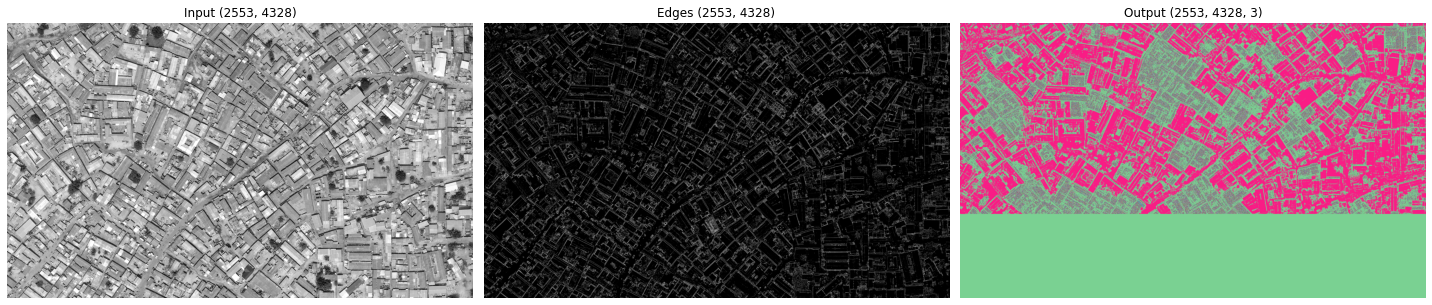

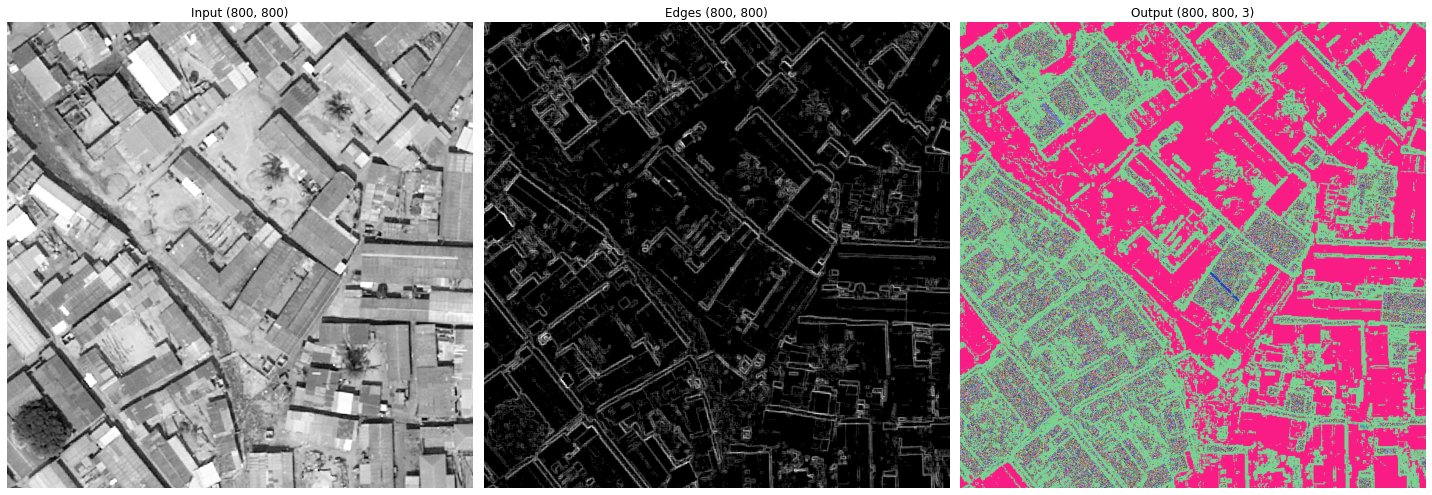

In [1057]:
image = load_image(ASSETS_FOLDER + 'primer1.jpg')
edges = edge_detection(image)
segmented = watershed(edges)

display_images(image, edges, segmented)
display_images(image[200:1000, 200:1000], edges[200:1000, 200:1000], segmented[200:1000, 200:1000, 0:3])

In [ ]:
image = load_image(ASSETS_FOLDER + 'primer1.jpg', cv2.COLOR_BGR2RGB)
#image = draw_on_image(image)

plt.imshow(image)
plt.axis('off')
plt.show()